# Homework 1 - Futues Spread Data Chacterization
By: Alex Huang

Date: January 13, 2024

UChicago ID: 12408153

## Imports

In [28]:
import os
import shutil
import platform
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import pandas as pd
import numpy as np
import scipy as sp

import quandl

pd.set_option('display.float_format', '{:.4f}'.format)

with open('api_key.txt', 'r') as file:
    API_KEY = file.read().strip()
HOME_DIR = r'C:\Users\Alex\Desktop\Academic\UChicago\FINM 33150'
# HOME_DIR = r'/Users/alexhuang/Documents/Academic/FINM 33150'

LOWER_DATE = '2020-12-03'
UPPER_DATE = '2023-08-31'

symbol_mapping = {
    'US': 'US30Y',
    'FV': 'US05Y',
    'TU': 'US02Y',
}

## Functions

In [29]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(HOME_DIR, "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.makedirs(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=API_KEY, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            current_os = platform.system()
            if current_os == 'Windows':
                shutil.copy(
                    data_file, data_symlink
                )
            else:
                os.symlink(
                    data_file, data_symlink,
                )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )




In [30]:
def compute_moving_average(price_series: pd.Series, window: int, min_window: int=None) -> pd.Series:
    if min_window:
        ma_series = price_series.rolling(window=window, min_periods=min_window).mean()
    else:
        ma_series = price_series.rolling(window=window).mean()
    ma_series.name = f'ma_{window}'
    return ma_series
def compute_moving_average_signal(price_series: pd.Series, moving_average_series: pd.Series, negative_signal: bool=False) -> pd.Series:
    sell_signal_value = -1 if negative_signal else 0
    return pd.Series(np.where(price_series > moving_average_series, 1, sell_signal_value), index=price_series.index, name=moving_average_series.name+"_signal")
def compute_portfolio_value_series(returns: pd.Series, signal: pd.Series, starting_value: int=10_000):
    portfolio_values = pd.DataFrame(index=returns.index)
    portfolio_values['returns_post_signal'] = (returns/100 * signal)
    portfolio_values['portfolio_value'] = (1 + portfolio_values['returns_post_signal']).cumprod() * starting_value
    # idx_of_first_buy = (signal == 1).idxmax()
    idx_of_first_buy = signal[(signal == 1)].index.min()
    portfolio_values.loc[signal.index[0]:idx_of_first_buy, 'portfolio_value'] = starting_value
    return portfolio_values['portfolio_value']

def compute_portfolio_statistics(portfolio_values: pd.Series=None, portfolio_returns: pd.Series=None, signals: pd.Series=None):
    PERIODS_PER_YEAR = 252
    if portfolio_returns is None and portfolio_values is None:
        raise Exception("No args given.")
    if portfolio_values is not None and isinstance(portfolio_values, pd.Series):
        portfolio_returns = portfolio_values.pct_change()
    statistics = portfolio_returns.to_frame(name='Portfolio Return Statistics').describe().transpose()
    if signals is not None and isinstance(signals, pd.Series):
        trade_data = signals[(signals != signals.shift(1).bfill())].value_counts()
        statistics['trade_count'] = trade_data.sum()
        statistics['buy_count'] = trade_data.loc[1]
        statistics['sell_count'] = statistics['trade_count'] - statistics['buy_count']
    statistics['total_return'] = np.product((1 + portfolio_returns)) - 1
    statistics['annual_return'] = (statistics['total_return'] + 1) ** (PERIODS_PER_YEAR / statistics['count']) - 1
    statistics['annual_vol'] = (statistics['std']) * (PERIODS_PER_YEAR) ** 0.5
    statistics['annual_return_per_annual_std'] = statistics['annual_return'] / statistics['annual_vol']
    statistics.columns = [col.replace("_", " ").title() for col in statistics.columns]
    return statistics.transpose()

In [31]:
def plot_ma_portfolio_performance(price_series: pd.Series, 
                                  ma_series: pd.Series, 
                                  ma_signal: pd.Series,
                                  portfolio_value_series: pd.Series,
                                  buy_hold_series: pd.Series=pd.Series(dtype='float64'),
                                  y_label_left: str='Spread and Moving Average',
                                  title: str='Moving Average Strategy Performance'):
    df = pd.concat([price_series.to_frame(), ma_series.to_frame(), ma_signal.to_frame(), portfolio_value_series.to_frame(), buy_hold_series.to_frame()], axis=1)
    # Define the buy_sell_dates series
    if isinstance(ma_signal, pd.Series) and not ma_signal.empty:
        buy_sell_dates: pd.Series = df[df[ma_signal.name] != df[ma_signal.name].shift(1).bfill()][ma_signal.name]
    else:
        buy_sell_dates: pd.Series = pd.Series(dtype='float64')

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot spread and moving average on the left y-axis
    ax1.plot(df[price_series.name], label=" ".join([w.capitalize() for w in price_series.name.split("_")]), color='blue')
    if isinstance(ma_series, pd.Series) and not ma_series.empty:
        ax1.plot(df[ma_series.name], label=" ".join([w.capitalize() for w in ma_series.name.split("_")]), color='green')

    # Create a second y-axis for portfolio value
    ax2 = ax1.twinx()
    ax2.plot(df[portfolio_value_series.name], label=" ".join([w.capitalize() for w in portfolio_value_series.name.split("_")]), color='red')
    if not buy_hold_series.empty:
        ax2.plot(df[buy_hold_series.name], label=" ".join([w.capitalize() for w in buy_hold_series.name.split("_")]), color='purple')

    # Set labels and legend
    ax1.set_xlabel('Time')
    ax1.set_ylabel(y_label_left, color='black')
    ax2.set_ylabel('Portfolio Value', color='black')
    ax1.legend(loc='upper left')
    ax2.legend(loc='lower right')

    # Add arrows based on buy_sell_dates
    if not buy_sell_dates.empty:
        mutation_scale = 15
        arrow_scale = 1.25
        for date, signal in buy_sell_dates.items():
            color, location, label_color, label = ('green', -arrow_scale, 'green', 'B') if signal == 1 else ('red', arrow_scale, 'red', 'S')
            ax1.annotate(label, xy=(date, df['spread'].loc[date] - 0.1), xytext=(date, df['spread'].loc[date] - 0.1 + location),
                        arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle='-|>', mutation_scale=mutation_scale),
                        ha='center', va='center', color=label_color)
    plt.title(title)
    plt.show()


# Table of Contents

> - [**I. Introduction: Overview and Objective**](#i-introduction-overview-and-objective)
   >> - [1. Overview](#1-overview)
   >> - [2. Objective](#2-objective)
> - [**II. Gathering Data: Fetching, Filtering, Cleaning, and Validating Data**](#ii-gathering-data-fetching-filtering-cleaning-and-validating-data)
   >> - [1. Fetching Data](#1-fetching-data)
   >> - [2. Filtering/Cleaning Data](#2-filteringcleaning-data)
   >> - [3. Validating Data](#3-validating-data)
> - [**III. Exploration: Dynamics of the Spreads**](#iii-exploration-dynamics-of-the-spreads)
   >> - [1. US02Y and US05Y Spread](#1-us02y-and-us05y-spread)
   >> - [2. US30Y and US05Y Spread](#2-us30y-and-us05y-spread)
   >> - [3. Difference: US02Y/US05Y Spread - US30Y/US05Y Spread](#3-difference-us02yus05y-spread---us30yus05y-spread)
   >> - [4. Dynamics: US02Y/US05Y and US30Y/US05Y Relationships](#4-dynamics-us02yus05y-and-us30yus05y-relationships)
> - [**IV. Analysis: Deep Dive into Trends, Relationships, and Results**](#iv-analysis-deep-dive-into-trends-relationships-and-results)
   >> - [1. Momentum Trade: Moving Average Strategy](#1-momentum-trade-moving-average-strategy)
      >>> - [A. Momentum Strategy Overview](#a-momentum-strategy-overview)
      >>> - [B. Momentum Strategy Performance](#b-momentum-strategy-performance)
         >>>> - [a. US02Y and US05Y Spread](#a-us02y-and-us05y-spread)
         >>>> - [b. US30Y and US05Y Spread](#b-us30y-and-us05y-spread)
   >> - [2. Bear Flattening Trade: Long/Short Strategy](#2-bear-flattening-trade-longshort-strategy)
      >>> - [A. Bear Flattener Strategy Overview](#a-bear-flattener-strategy-overview)
      >>> - [B. Bear Flattener Strategy Performance](#b-bear-flattener-strategy-performance)
         >>>> - [a. Pair: US30Y/US05Y - US05Y/US02Y](#a-pair-us30yus05y---us05yus02y)
> - [**V. Conclusion: Summary of Results**](#v-conclusion-summary-of-results)
   >> - [1. Report Conclusion](#1-report-conclusion)

## I. Introduction: Overview and Objective

***
### 1. Overview

This is assignment we will be focusing on 2 US treasury note spreads; between the US 2 year note and the US 5 year note as well as the US 30 year bond and the US 5 year note. We will be looking at the date range between 2020-12-03 and 2023-08-31. 

### 2. Objective

The goal of this research is to characterize the dynamics of the US 2 year - 5 year spread and the US 30 year - 2 year spread. 

***

## II. Gathering Data: Fetching, Filtering, Cleaning, and Validating Data

***
### 1. Fetching Data

Here we fetch and filter the data we want from Quandl using the date range provided in this assignment.

In [32]:
t_ivm = fetch_quandl_table('AR/IVM', avoid_download=False)
t_ivm['date'] = pd.to_datetime(t_ivm['date'], format='%Y-%m-%d')
t_ivm = t_ivm[(t_ivm['date'] >= LOWER_DATE) & (t_ivm['date'] <= UPPER_DATE)]
t_ivm.head()

Data file C:\Users\Alex\Desktop\Academic\UChicago\FINM 33150\quandl_data_table_downloads\AR/IVM_20240130.zip size 291291827 exists already, no need to download


,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,V2024,2023-07-27,58.0400,0.3031,-0.0049,NaN,-0.0052,...,-0.0135,-0.2110,0.2741,1.6979,-1.0234,-4.1791,-0.5496,0.4442,421.2400,445.0000
2,NYM,NG,NG,F2029,2023-07-27,4.7030,0.3346,NaN,NaN,NaN,...,0.1593,0.1339,-1.1480,-1.0067,1.5905,1.4777,-0.7373,0.7544,1979.0000,1980.0000
4,CBT,BO,BO,1M,2023-07-27,67.3469,0.3529,-0.0029,-0.0060,0.0024,...,-0.0247,0.4203,-0.6440,23.5564,14.3529,-214.0050,-0.2224,0.2385,31.0000,31.0000
5,CBT,BO,BO,1W,2023-07-27,69.3828,0.3626,-0.0067,-0.0147,0.0028,...,-0.0984,2.0679,-5.2251,414.6859,571.5131,-15077.1939,-0.1060,0.1155,7.0000,7.0000
6,CBT,BO,BO,1Y,2023-07-27,60.0736,0.2996,-0.0023,0.0035,-0.0034,...,-0.0052,-0.1497,0.1520,1.2960,-0.6012,-3.3473,-0.5197,0.4437,366.0000,366.0000


***
### 2. Filtering/Cleaning Data
We filter for the forward contracts of the US 2 year and the US 5 year contracts and apply a 1.1066 multiplier to the US 2 year for better scale. We then filter for the US 30 year and the US 5 year contracts and apply a 0.7595 multiplier on the US 30 year for scale as well. A filter is also applied so that we obtain the contract whose days until termination is the smallest given that it is still greater than 30 days.

In [47]:
def filter_spread(code1: str, code2: str, multiplier: float):
    tu_df = t_ivm[(t_ivm['futures_code'] == code1) & (t_ivm['days_termination'] > 30)]
    fv_df = t_ivm[(t_ivm['futures_code'] == code2) & (t_ivm['days_termination'] > 30)]
    tu_df = tu_df[tu_df['expiration'].str.startswith(('H','M','U','Z'))]
    fv_df = fv_df[fv_df['expiration'].str.startswith(('H','M','U','Z'))]

    tu_df = tu_df.loc[tu_df.groupby('date')['days_termination'].idxmin()]
    fv_df = fv_df.loc[fv_df.groupby('date')['days_termination'].idxmin()]

    tu_df.index = tu_df['date']
    fv_df.index = fv_df['date']

    df1 = tu_df[['futures_code', 'days_termination', 'futures']]
    df2 = fv_df[['futures_code', 'days_termination', 'futures']]
    df = df1.merge(df2, how='outer', left_index=True, right_index=True,suffixes=(f'_{code1.lower()}', f'_{code2.lower()}'))

    df['spread'] = (df[f'futures_{code1.lower()}'] * multiplier) - df[f'futures_{code2.lower()}']
    return df



us2_minus_us5_df = filter_spread('TU', 'FV', 1.1066)
us30_minus_us5_df = filter_spread('US', 'FV', 0.7595)

***
### 3. Validating Data

Here, we also apply some assert statements to ensure that we have the proper data from Quandl and that we have properly retreived and filtered the dataframe.

In [48]:
assert np.isclose(us2_minus_us5_df.loc['2021-11-25', 'spread'], 0.156306)
assert np.isclose(us2_minus_us5_df.loc['2021-11-26', 'spread'], -0.18187656249999407)

assert np.isclose(us30_minus_us5_df.loc['2021-11-19', 'spread'], 1.271594)
assert np.isclose(us30_minus_us5_df.loc['2021-11-24', 'spread'], -0.658906)
assert np.isclose(us30_minus_us5_df.loc['2021-11-26', 'spread'], 1.274656)

## III. Exploration: Dynamics of the Spreads

### 1. US02Y and US05Y Spread
---

#### **Spread:** US02Y and the US05Y

During the selected time period, the spread of the US 2 year and the US 5 year seemed to have widen in the positive direction signficiantly. This is likely due to the fact that the US Federal Reserve began hiking interest rates aggresively around March of 2022 and announcing those hikes before then.

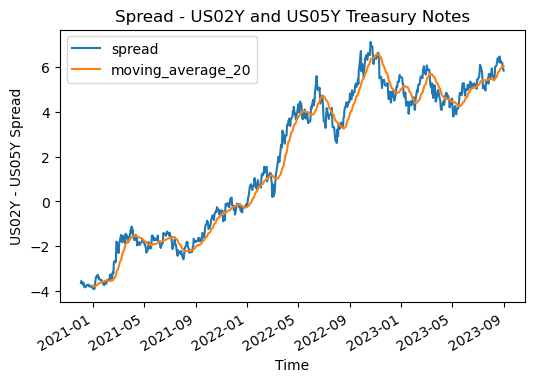

In [49]:
window_size = 20
us2_minus_us5_df[f'moving_average_{window_size}'] = us2_minus_us5_df['spread'].rolling(window=window_size).mean()

us2_minus_us5_df[['spread', f'moving_average_{window_size}']].plot.line(figsize=(6,4))

# Add labels and title
plt.xlabel('Time')
plt.ylabel('US02Y - US05Y Spread')
plt.title('Spread - US02Y and US05Y Treasury Notes')

# Show the plot
plt.show()

#### **Price Changes:** US02Y and the US05Y

We can see relatively consistent volatility in the price changes over time with slightly higher volatility near the time the US Federal Reserve announces rate hikes.

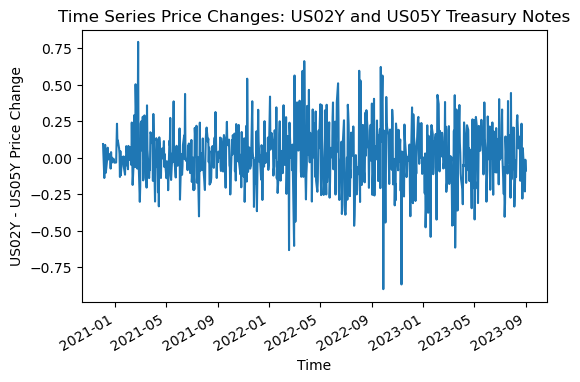

In [50]:
us2_minus_us5_df['price_change'] = us2_minus_us5_df['spread'] - us2_minus_us5_df['spread'].shift(1)
us2_minus_us5_df['price_change'].plot.line(figsize=(6,4))

# Add labels and title
plt.xlabel('Time')
plt.ylabel('US02Y - US05Y Price Change')
plt.title('Time Series Price Changes: US02Y and US05Y Treasury Notes')

# Show the plot
plt.show()

The histogram below is roughly symmetric with a mean slightly left of zero. This is likely because of the trend during this time period when the US Federal Reserve is hiking interest rates aggresively.

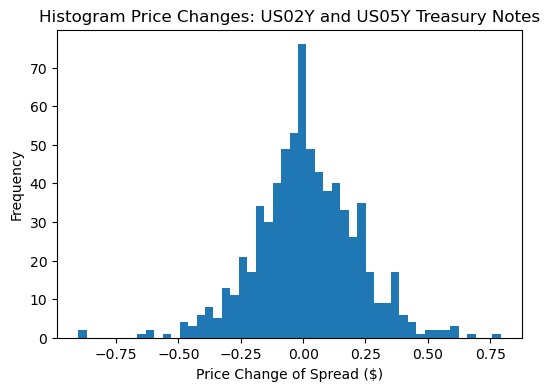

In [51]:
us2_minus_us5_df['price_change'].plot.hist(figsize=(6,4), bins=50)

# Add labels and title
plt.xlabel(r'Price Change of Spread ($)')
plt.ylabel('Frequency')
plt.title('Histogram Price Changes: US02Y and US05Y Treasury Notes')

# Show the plot
plt.show()

Here in the autocorrelation of the US02Y and US05Y, we can see little autocorrelation of the price changes as expected. The market would likely trade on autocorrelation if it had existed.

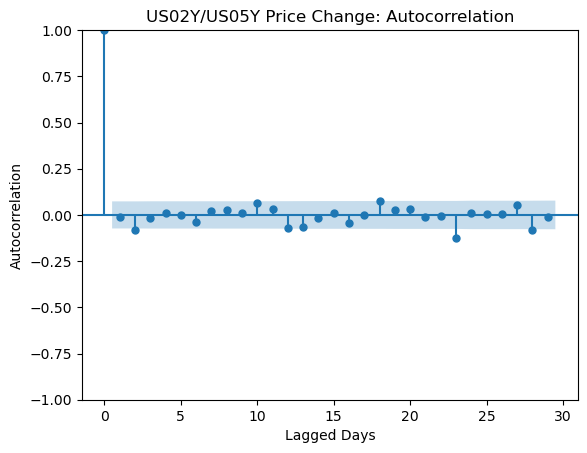

In [52]:
sm.graphics.tsa.plot_acf(us2_minus_us5_df['price_change'].fillna(0))
plt.xlabel("Lagged Days")
plt.ylabel("Autocorrelation")
plt.title("US02Y/US05Y Price Change: Autocorrelation")
plt.show()


#### **Returns:** US02Y and the US05Y

Looking at the returns of the US 2 year and the US 5 year spread, we can see again, relatively consistent volatility in the returns over time. 

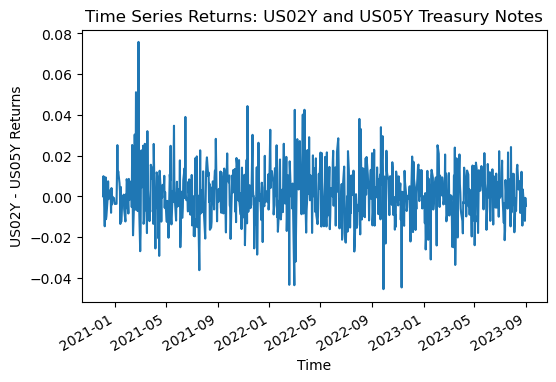

In [53]:
price_scaling_factor = abs(us2_minus_us5_df['spread'].min() * us2_minus_us5_df['spread'].std())

us2_minus_us5_df['returns'] = (us2_minus_us5_df['spread'] + price_scaling_factor).pct_change().fillna(0)

us2_minus_us5_df['returns'].plot.line(figsize=(6,4))

# Add labels and title
plt.xlabel('Time')
plt.ylabel('US02Y - US05Y Returns')
plt.title('Time Series Returns: US02Y and US05Y Treasury Notes')

# Show the plot
plt.show()

In the histogram below, we can see that the distribution of returns is symmetric and centered at near zero.

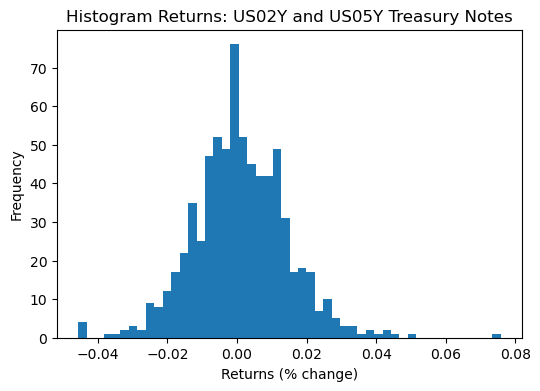

In [54]:
us2_minus_us5_df['returns'].plot.hist(figsize=(6,4), bins=50)

# Add labels and title
plt.xlabel(r'Returns (% change)')
plt.ylabel('Frequency')
plt.title('Histogram Returns: US02Y and US05Y Treasury Notes')

# Show the plot
plt.show()

In the autocorrelation chart below, we can see that the timeseries of returns exhibit, mostly non-significant and low autocorrelations.

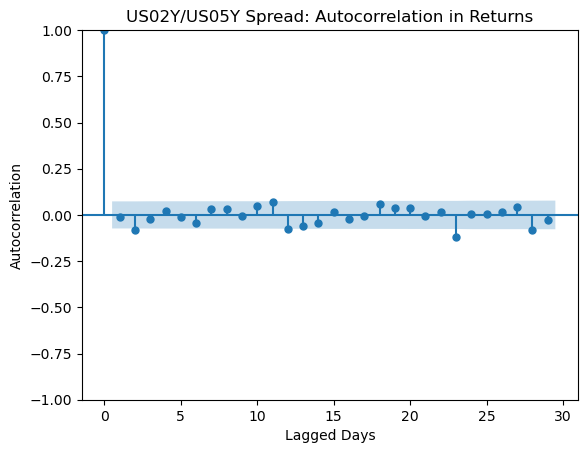

In [55]:
sm.graphics.tsa.plot_acf(us2_minus_us5_df['returns'].fillna(0))
plt.xlabel("Lagged Days")
plt.ylabel("Autocorrelation")
plt.title("US02Y/US05Y Spread: Autocorrelation in Returns")
plt.show()


#### **Conclusion:** Dynamics of US02Y and US05Y Spread

Mean returns of the spread are near zero with what looks like a somewhat symmetric distribution. Spread statistics for this time period indicate an inverted yield curve which is what we are currently observing in the markets. Price changes indicate a 1.3 cent change per day on average. By looking at the standard deviation of the mean returns and mean price changes, we can see that the means are statistically significant from zero.

In [56]:
statistics = us2_minus_us5_df[['spread', 'price_change', 'returns']].describe()
statistics.loc['std_mean', 'price_change'] = statistics.loc['std','price_change'] / (statistics.loc['count','price_change'] ** 0.5)
statistics.loc['std_mean', 'returns'] = statistics.loc['std','returns'] / (statistics.loc['count','returns'] ** 0.5)
statistics

,spread,price_change,returns
count,715.0000,714.0000,715.0000
mean,1.9002,0.0133,0.0011
std,3.3209,0.2043,0.0136
min,-3.9325,-0.9021,-0.0456
25%,-1.5629,-0.1034,-0.0073
50%,3.3011,0.0037,0.0002
75%,4.8944,0.1369,0.0098
max,7.1261,0.7930,0.0758
std_mean,NaN,0.0076,0.0005


### 2. US30Y and US05Y Spread

#### **Spread:** US30Y and US05Y

In the timeseries of the spread between US 30 year nad US 5 year we can see that the spread has been widening in the negative direction, indicating a yield curve inversion. This is consistent with what we have seen in the previous section (but inverted since the long term bond is at the front). Except, here in this chart, we can more clearly see that the spread begins to widen around March of 2022 when the US Federal Reserve begins to raise rates.

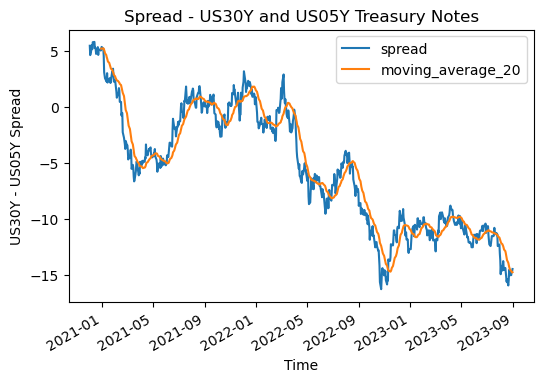

In [57]:
window_size = 20
us30_minus_us5_df[f'moving_average_{window_size}'] = us30_minus_us5_df['spread'].rolling(window=window_size).mean()

us30_minus_us5_df[['spread', f'moving_average_{window_size}']].plot.line(figsize=(6,4))
plt.xlabel('Time')
plt.ylabel('US30Y - US05Y Spread')
plt.title('Spread - US30Y and US05Y Treasury Notes')
plt.show()

#### **Price Changes:** US30Y and the US05Y

We can see relatively consistent volatility in the price changes over time with slightly higher volatility near the time the US Federal Reserve announces rate hikes.

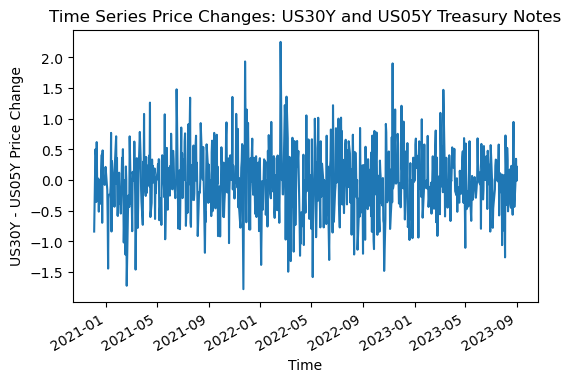

In [58]:
us30_minus_us5_df['price_change'] = us30_minus_us5_df['spread'] - us30_minus_us5_df['spread'].shift(1)
us30_minus_us5_df['price_change'].plot.line(figsize=(6,4))

# Add labels and title
plt.xlabel('Time')
plt.ylabel('US30Y - US05Y Price Change')
plt.title('Time Series Price Changes: US30Y and US05Y Treasury Notes')

# Show the plot
plt.show()

In the histrogram below of the price change of the spread, we can see a roughly symmetric distribution with many observations slightly left of the zero. Similar to the price changes observed in the US02Y/US05Y spread, the slight left shift of the distribution is likely due to the time period being in a period of aggressive rate hikes in the US.

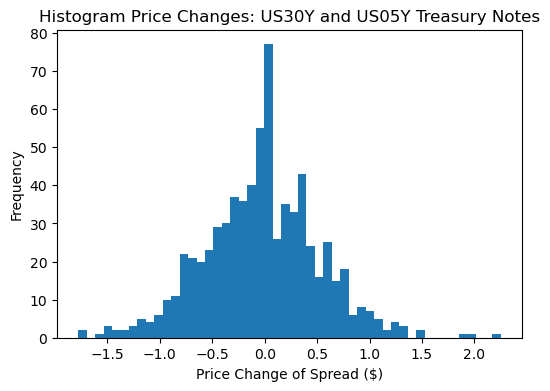

In [59]:
us30_minus_us5_df['price_change'].plot.hist(figsize=(6,4), bins=50)

# Add labels and title
plt.xlabel(r'Price Change of Spread ($)')
plt.ylabel('Frequency')
plt.title('Histogram Price Changes: US30Y and US05Y Treasury Notes')

# Show the plot
plt.show()

Similar to what we've see from the US02Y/US05Y spread, the autocorrelation should be low and not significant as explained previously.

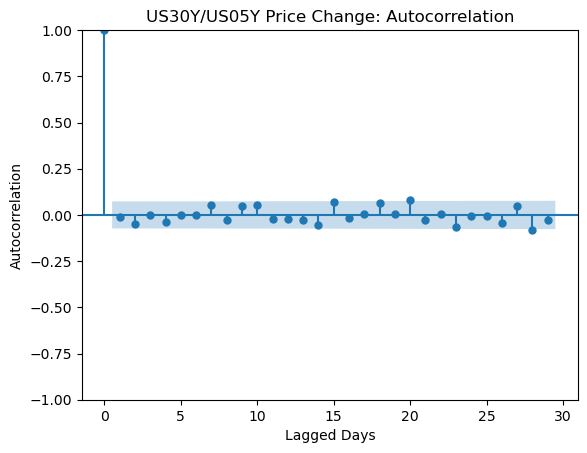

In [60]:
sm.graphics.tsa.plot_acf(us30_minus_us5_df['price_change'].fillna(0))
plt.xlabel("Lagged Days")
plt.ylabel("Autocorrelation")
plt.title("US30Y/US05Y Price Change: Autocorrelation")
plt.show()


#### **Returns:** US30Y and the US05Y

In this visualization we see pretty similar results compared to the previous series. The volatility looks roughly constant through time with a couple of spikes, likely when on the weeks Federal Reserve announces rate hike decisions.

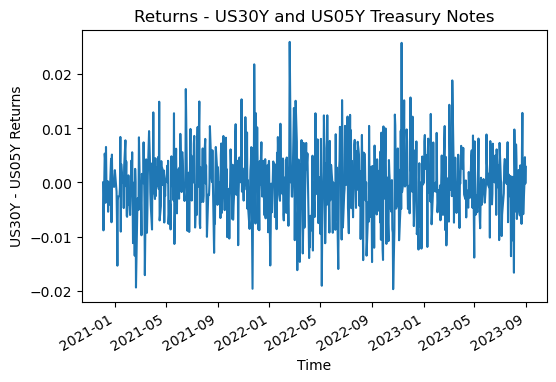

In [61]:
price_scaling_factor = abs(us30_minus_us5_df['spread'].min() * us30_minus_us5_df['spread'].std())

us30_minus_us5_df['returns'] = (us30_minus_us5_df['spread'] + price_scaling_factor).pct_change().fillna(0)

us30_minus_us5_df['returns'].plot.line(figsize=(6,4))

plt.xlabel('Time')
plt.ylabel('US30Y - US05Y Returns')
plt.title('Returns - US30Y and US05Y Treasury Notes')
plt.show()

We can see from the histogram of returns that they are very heavily centered with some outliers and shocks in the returns. The distribution also looks slightly shifted towards the negative end.

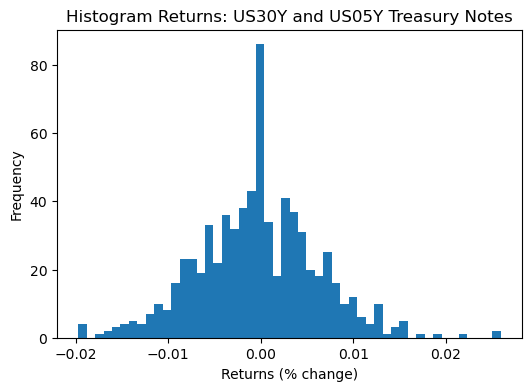

In [62]:
us30_minus_us5_df['returns'].plot.hist(figsize=(6,4), bins=50)
plt.xlabel(r'Returns (% change)')
plt.ylabel('Frequency')
plt.title('Histogram Returns: US30Y and US05Y Treasury Notes')
plt.show()

#### Conclusion: Dynamics of US30Y and US05Y Spread

In the spread timeseries statistics, we observe that its mean was negative, indicating a downward slope between the US 30-year and US 5-year, as seen from the timeseries. Over the period of interest, the yield curve became more inverted, consistent with the Fed aggressively hiking rates.

For the price change timeseries statistics, the average daily change was -2.8 cents with a standard error of 2.1 cents, indicating that the mean price change was statistically significant from zero. The distribution of the price changes looks relatively normal with a slight shift to the negative side.

Regarding the return timeseries statistics, we note a mean return of -0.03% with a standard error of 0.02%, also indicating significance. The distribution of the returns looked relatively normal, with a slight shift to the negative side as well.

In [63]:
statistics = us30_minus_us5_df[['spread', 'price_change', 'returns']].describe()
statistics.loc['std_mean', 'price_change'] = statistics.loc['std','price_change'] / (statistics.loc['count','price_change'] ** 0.5)
statistics.loc['std_mean', 'returns'] = statistics.loc['std','returns'] / (statistics.loc['count','returns'] ** 0.5)
statistics

,spread,price_change,returns
count,715.0000,714.0000,715.0000
mean,-5.5231,-0.0280,-0.0003
std,5.4775,0.5470,0.0065
min,-16.3057,-1.7791,-0.0197
25%,-10.6336,-0.3684,-0.0044
50%,-5.3569,-0.0126,-0.0001
75%,-0.6611,0.3230,0.0039
max,5.8219,2.2524,0.0260
std_mean,NaN,0.0205,0.0002


##### Autocorrelation

Looking at the autocorrelation of the returns, we can already see very minimal autocorrelation in the timeseries. This is as expected if the market were efficient.

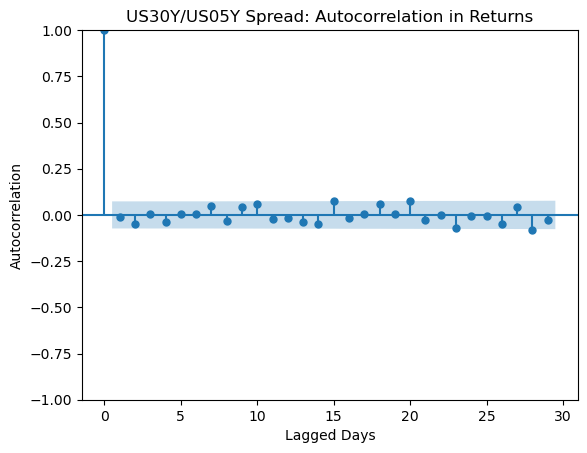

In [64]:
sm.graphics.tsa.plot_acf(us30_minus_us5_df['returns'].fillna(0))
plt.xlabel("Lagged Days")
plt.ylabel("Autocorrelation")
plt.title("US30Y/US05Y Spread: Autocorrelation in Returns")
plt.show()


### 3. Difference US02Y/US05Y Spread - US30Y/US05Y Spread

#### **Spread:** US02Y/US05Y - US30Y/US05Y Difference

We will plot the difference between the two spreads analyzed in the previous section. There's not too much surprises here and the series is pretty much as expected since they are both treasury spreads, it is similar to a portfolio of bonds on different maturities on the yield curve.

In [65]:
difference_df = us2_minus_us5_df[['spread']].merge(us30_minus_us5_df[['spread']], left_index=True, right_index=True, how='outer', suffixes=('_TUFV', '_USFV'))
difference_df['difference_USFV_minus_TUFV'] = difference_df['spread_USFV'] - difference_df['spread_TUFV']
difference_df['difference_TUFV_minus_USFV'] = difference_df['spread_TUFV'] - difference_df['spread_USFV']

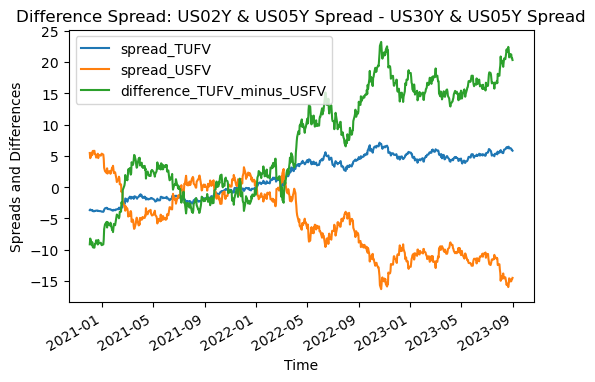

In [66]:
difference_df[['spread_TUFV', 'spread_USFV', 'difference_TUFV_minus_USFV']].plot.line(figsize=(6, 4))

plt.xlabel("Time")
plt.ylabel("Spreads and Differences")
plt.title("Difference Spread: US02Y & US05Y Spread - US30Y & US05Y Spread")
plt.show()

#### **Price Changes:** US02Y/US05Y - US30Y/US05Y Difference

We can see relatively consistent volatility in the price changes over time with slightly higher volatility near the time the US Federal Reserve announces rate hikes.

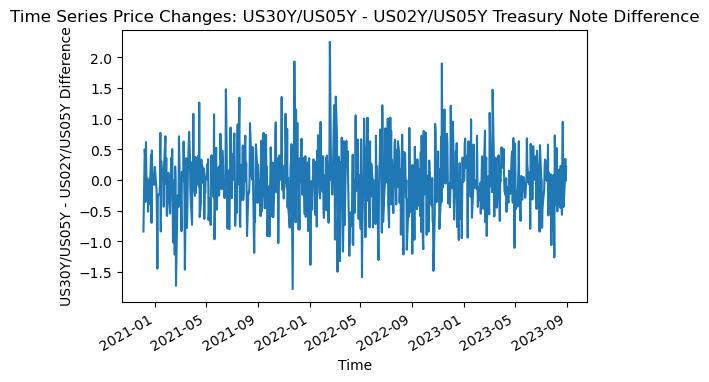

In [67]:
difference_df['price_change'] = difference_df['difference_TUFV_minus_USFV'] - difference_df['difference_TUFV_minus_USFV'].shift(1)
us30_minus_us5_df['price_change'].plot.line(figsize=(6,4))

# Add labels and title
plt.xlabel('Time')
plt.ylabel('US30Y/US05Y - US02Y/US05Y Difference')
plt.title('Time Series Price Changes: US30Y/US05Y - US02Y/US05Y Treasury Note Difference')

# Show the plot
plt.show()

Since we are taking the difference of the two distributions from earlier, it is as expected the this distribution is also negatively shifted.

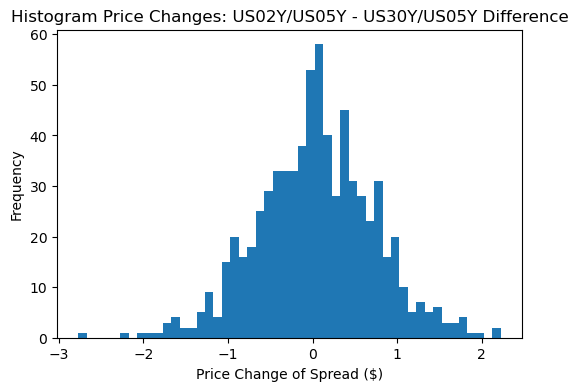

In [68]:
difference_df['price_change'].plot.hist(figsize=(6,4), bins=50)

# Add labels and title
plt.xlabel(r'Price Change of Spread ($)')
plt.ylabel('Frequency')
plt.title('Histogram Price Changes: US02Y/US05Y - US30Y/US05Y Difference')

# Show the plot
plt.show()

Again, low autocorrelation as one would expect from the market.

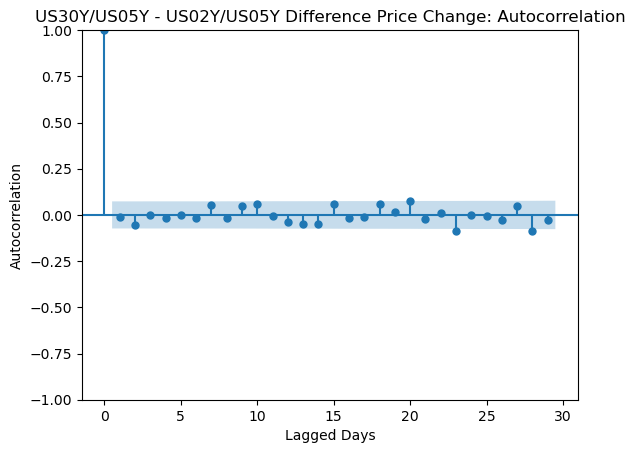

In [69]:
sm.graphics.tsa.plot_acf(difference_df['price_change'].fillna(0))
plt.xlabel("Lagged Days")
plt.ylabel("Autocorrelation")
plt.title("US30Y/US05Y - US02Y/US05Y Difference Price Change: Autocorrelation")
plt.show()


#### **Returns:** US02Y/US05Y - US30Y/US05Y Difference

In the two charts below we can see that the returns are centered aroudn zero with low volatility in normal circumstances with a couple large shocks to the returns slightly before and after the US Federal Reserves initial rate hike in March of 2022.

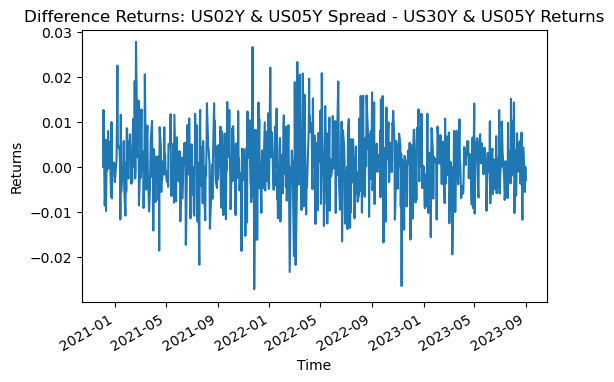

In [70]:
price_scaling_factor = abs(difference_df['difference_TUFV_minus_USFV'].min() * difference_df['difference_TUFV_minus_USFV'].std())
difference_df['returns'] = (difference_df['difference_TUFV_minus_USFV'] + price_scaling_factor).pct_change().fillna(0)

difference_df['returns'].plot.line(figsize=(6, 4))

plt.xlabel("Time")
plt.ylabel("Returns")
plt.title("Difference Returns: US02Y & US05Y Spread - US30Y & US05Y Returns")
plt.show()

The distribution of returns also exhibits similar behavior as the price change of the differece, as one would expect. The distribution of returns is centered near zero, slight negative shift, with a symmentric distribution.

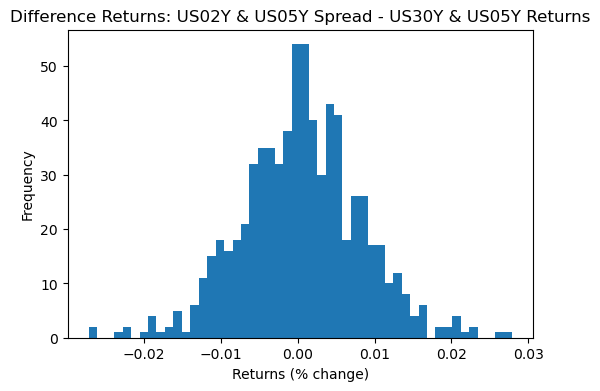

In [71]:
difference_df['returns'].plot.hist(figsize=(6, 4), bins=50)

plt.xlabel(r"Returns (% change)")
plt.ylabel("Frequency")
plt.title("Difference Returns: US02Y & US05Y Spread - US30Y & US05Y Returns")
plt.show()

Autocorrelations, again are near zero and not significant as previously inspected in all the other spreads and difference metrics.

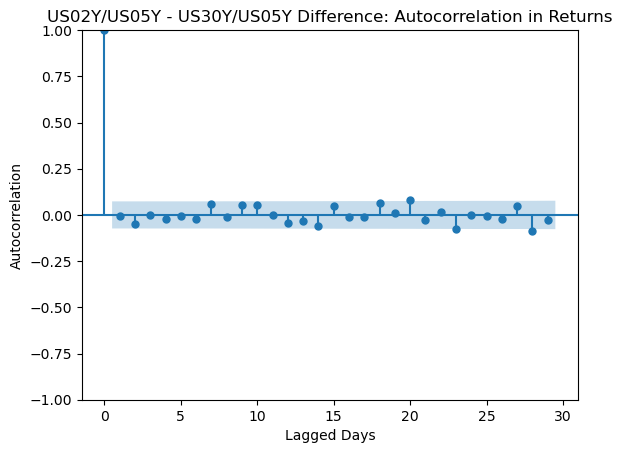

In [72]:
sm.graphics.tsa.plot_acf(difference_df['returns'].fillna(0))
plt.xlabel("Lagged Days")
plt.ylabel("Autocorrelation")
plt.title("US02Y/US05Y - US30Y/US05Y Difference: Autocorrelation in Returns")
plt.show()


#### **Conclusion:** Dynamics of US02Y/US05Y - US30Y/US05Y Difference

From the statistics below, we can see significance in the mean of both the price change and the returns. As seen earlier from the histograms, there is a symmetric distribution with a very slight positive shift in the positive direction for this time period. 

Additionally, we can see that the mean difference between the US30Y/US05Y and the US02Y/US05Y is negative. This is consistent with the movement in the yield curve seen during this time period and will lead into one of our trading strategies demonstrated later.

In [73]:
statistics = difference_df[['difference_USFV_minus_TUFV', 'price_change', 'returns']].describe()
statistics.loc['std_mean', 'price_change'] = statistics.loc['std','price_change'] / (statistics.loc['count','price_change'] ** 0.5)
statistics.loc['std_mean', 'returns'] = statistics.loc['std','returns'] / (statistics.loc['count','returns'] ** 0.5)
statistics

,difference_USFV_minus_TUFV,price_change,returns
count,715.0000,714.0000,715.0000
mean,-7.4234,0.0413,0.0005
std,8.5525,0.6940,0.0078
min,-23.2396,-2.7716,-0.0272
25%,-15.3760,-0.3895,-0.0044
50%,-7.7771,0.0434,0.0005
75%,-0.2881,0.4678,0.0053
max,9.6675,2.2258,0.0278
std_mean,NaN,0.0260,0.0003


### 4. Dynamics: US02Y/US05Y and US30Y/US05Y Relationships

#### **Spread:** Correlation

In the following scatter plot between the US05Y/US02Y and the US30Y/US05Y we can see very high correlation between the two. Notice that I have ran the correlation with negative US02Y/US05Y to get a positive correlation. The reason for this is that the both spreads now indicate an upward steepening of the yield curve if positive and a downard steepening of the yield curve (or flattening) if negative.

Correlation is 0.883 since both spreads essentially reflect changes in the yield curve.

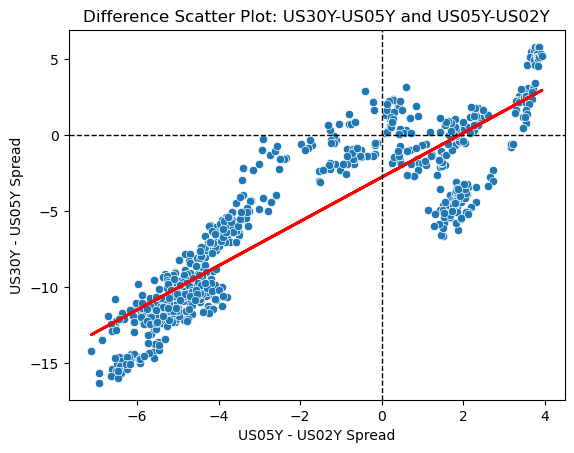

                            OLS Regression Results                            
Dep. Variable:            spread_USFV   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     2516.
Date:                Mon, 15 Jan 2024   Prob (F-statistic):          4.59e-236
Time:                        15:58:33   Log-Likelihood:                -1690.0
No. Observations:                 715   AIC:                             3384.
Df Residuals:                     713   BIC:                             3393.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.7564      0.111    -

In [74]:
difference_df['inv_spread_TUFV'] = difference_df['spread_TUFV'] * -1
sns.scatterplot(x='inv_spread_TUFV', y='spread_USFV', data=difference_df)
plt.xlabel("US05Y - US02Y Spread")
plt.ylabel("US30Y - US05Y Spread")
plt.title("Difference Scatter Plot: US30Y-US05Y and US05Y-US02Y")

X = sm.add_constant(difference_df['inv_spread_TUFV'])
y = difference_df['spread_USFV']

model = sm.OLS(y, X).fit()

plt.plot(difference_df['inv_spread_TUFV'], model.predict(X), color='red', linewidth=2)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.show()

print(model.summary())


#### **Conclusion:** Regression Results

In the regression statistics above, we can see that the model is highly significant with an extremely low F-statistic. It is a reasonably good model with an R-squared of 0.779.

Additionally the slope of the regression is significantly different from zero, at 1.456, which indicates that for every 1 dollar change in the US05Y/US02Y spread there is a 1.456 dollar change in the US30Y/US05Y spread. 

This is likely because the the US 30 year treasury has much higher duration and is much more sensitive to yield curvve changes than a US 2 year treasury.

## IV. Analysis: Deep Dive into Trends, Relationships, and Results

### 1. Momentum Trade: Moving Average Strategy
---

#### A. Momentum Strategy Overview
---

In this momentum strategy, we will test a basic moving average strategy and measure its performance over the given time period. The moving average period chosen for this strategy is 60 days. This strategy buys and holds the spread when the spread crosses the moving average from below and sells and shorts (reverses) the position when the spread crosses the moving average from above.


**NOTE: Since we are dealing with spreads the leverage of this strategy becomes much higher when the spread is cheap (very close to zero). This strategy does not normalize the position based on the spread amount.**

#### B. Momentum Strategy Performance
---

**Summary:** In utilizing a 60-day moving average momentum strategy, there is consistent outperformance relative to the buy-and-hold strategy. In the latest comparison, the buy-and-hold strategy yielded a -14% return, while the moving average strategy achieved a -3% return, indicating a more significant outperformance. However, it's crucial to consider the impact of volatility spikes near zero, as returns in this region can substantially influence the portfolio's performance compared to the buy-and-hold approach. Overall, the moving average strategy demonstrates an outperformance, showcasing its potential effectiveness in navigating market dynamics for this time period.

##### a. US02Y and US05Y Spread

Utilizing a 60-day moving average momentum trading strategy, we have identified a profitable approach (excluding considerations for slippage and trading costs, which necessitate more thorough testing). While this strategy has outperformed the buy-and-hold strategy, the margin of outperformance is not substantial and may not be statistically significant.

##### Visualization of Porfolio Performance

In [75]:
buy_hold_signal = pd.Series(np.ones(us2_minus_us5_df.shape[0]))
buy_hold_signal[0] = 0
buy_hold_signal.index = us2_minus_us5_df.index
buy_hold_series = compute_portfolio_value_series(us2_minus_us5_df['returns'], buy_hold_signal)
buy_hold_series.name = 'Buy Hold Portfolio'

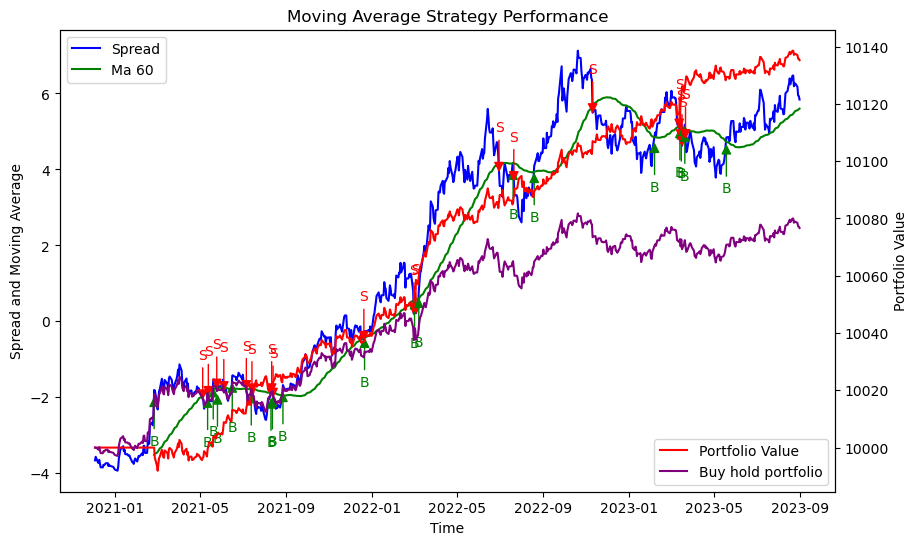

In [76]:
window_size = 60
ma_series = compute_moving_average(us2_minus_us5_df['spread'], 60)
ma_signal = compute_moving_average_signal(us2_minus_us5_df['spread'], ma_series, True)
ma_portfolio_series = compute_portfolio_value_series(us2_minus_us5_df['returns'], ma_signal)
ma_us2_minus_us5_df = pd.concat([us2_minus_us5_df[['spread', 'returns']], ma_series, ma_signal, ma_portfolio_series], axis=1)
plot_ma_portfolio_performance(
    ma_us2_minus_us5_df['spread'], 
    ma_us2_minus_us5_df['ma_60'],
    ma_us2_minus_us5_df['ma_60_signal'],
    ma_us2_minus_us5_df['portfolio_value'],
    buy_hold_series
)

##### Moving Average vs Buy and Hold Statistics

In [77]:
pd.concat(
    [
        compute_portfolio_statistics(ma_us2_minus_us5_df['portfolio_value'], signals=ma_signal),
        compute_portfolio_statistics(buy_hold_series, signals=buy_hold_signal).rename(columns={'Portfolio Return Statistics': 'Buy Hold Statistics'})
    ],
    axis=1
)

,Portfolio Return Statistics,Buy Hold Statistics
Count,714.0000,714.0000
Mean,0.0000,0.0000
Std,0.0001,0.0001
Min,-0.0005,-0.0005
25%,-0.0001,-0.0001
50%,0.0000,0.0000
75%,0.0001,0.0001
Max,0.0004,0.0008
Trade Count,37.0000,1.0000
Buy Count,19.0000,1.0000


##### b. US30Y and US05Y Spread

Once again, employing a 60-day moving average momentum strategy has allowed us to outperform the buy-and-hold strategy. This time, the outperformance appears to be more significant.

The buy-and-hold strategy concluded this period with a approximately -0.022% return, while the moving average strategy finished with a 0.08% return. This difference is small, but also it's essential to bear in mind the volatility spike when the spread is near zero. Returns in this region can significantly impact portfolio performance relative to the buy-and-hold strategy.

##### Visualization of Porfolio Performance

In [78]:
buy_hold_signal = pd.Series(np.ones(us30_minus_us5_df.shape[0]))
buy_hold_signal[0] = 0
buy_hold_signal.index = us30_minus_us5_df.index
buy_hold_series = compute_portfolio_value_series(us30_minus_us5_df['returns'], buy_hold_signal)
buy_hold_series.name = 'Buy Hold Portfolio'

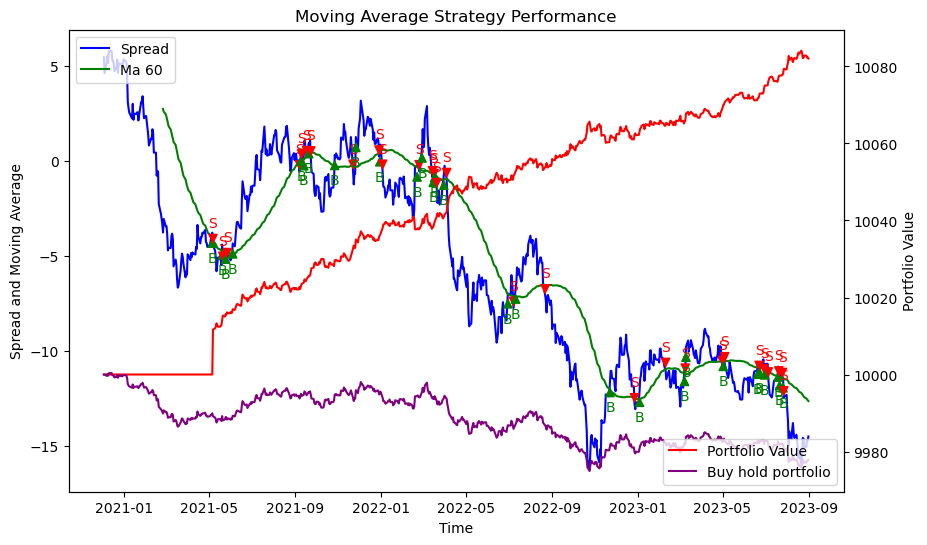

In [79]:
window_size = 60
ma_series = compute_moving_average(us30_minus_us5_df['spread'], window_size)
ma_signal = compute_moving_average_signal(us30_minus_us5_df['spread'], ma_series, True)
ma_portfolio_series = compute_portfolio_value_series(us30_minus_us5_df['returns'], ma_signal)
ma_us30_minus_us5_df = pd.concat([us30_minus_us5_df[['spread', 'returns']], ma_series, ma_signal, ma_portfolio_series], axis=1)
plot_ma_portfolio_performance(
    ma_us30_minus_us5_df['spread'], 
    ma_series,
    ma_signal,
    ma_us30_minus_us5_df['portfolio_value'],
    buy_hold_series
)

##### Moving Average vs Buy and Hold Statistics

Here we are able to see that the moving average strategy actually out performed the 

In [80]:
pd.concat(
    [
        compute_portfolio_statistics(ma_us30_minus_us5_df['portfolio_value'], signals=ma_signal),
        compute_portfolio_statistics(buy_hold_series, signals=buy_hold_signal).rename(columns={'Portfolio Return Statistics': 'Buy Hold Statistics'})
    ],
    axis=1
)

,Portfolio Return Statistics,Buy Hold Statistics
Count,714.0000,714.0000
Mean,0.0000,-0.0000
Std,0.0001,0.0001
Min,-0.0003,-0.0002
25%,-0.0000,-0.0000
50%,0.0000,-0.0000
75%,0.0000,0.0000
Max,0.0012,0.0003
Trade Count,56.0000,1.0000
Buy Count,28.0000,1.0000


### 2. Bear Flattening Trade: Long/Short Strategy
---

#### A. Bear Flattener Strategy Overview
---

A bear flattener is a term used in the context of the yield curve, which represents the relationship between interest rates and the maturity of debt. The yield curve can take various shapes, including upward-sloping, downward-sloping, or flat. A bear flattener specifically refers to a situation where the yield curve flattens, and short-term rates increase more than the long-term rates, resulting in a smaller spread between them (downward sloping in this case).

Here we are going take a long position in the US02Y/US05Y spread and take a short position in the US30Y/US05Y spread. We can already see that this portfolio will profit if the yield curve increases since we are trading one month FUTURES on these notes.

#### B. Bear Flattener Strategy Performance
---

In this implementation of the bear flattner strategy, we are going shift the difference by 20 then calculate the retuns since, as noted earlier, when the difference is near zero the leverage is extremely high (we reduce that by shifting the scale). We can see that the tracking is relatively close to the movement in the difference and the error is due to the shift in scale. Note that changes in shift will indicate the amount of leverage used during different time periods.

This buy and hold strategy has performed relatively decently and is on par with the moving average strategies.

##### a. Pair: US30Y/US05Y - US05Y/US02Y

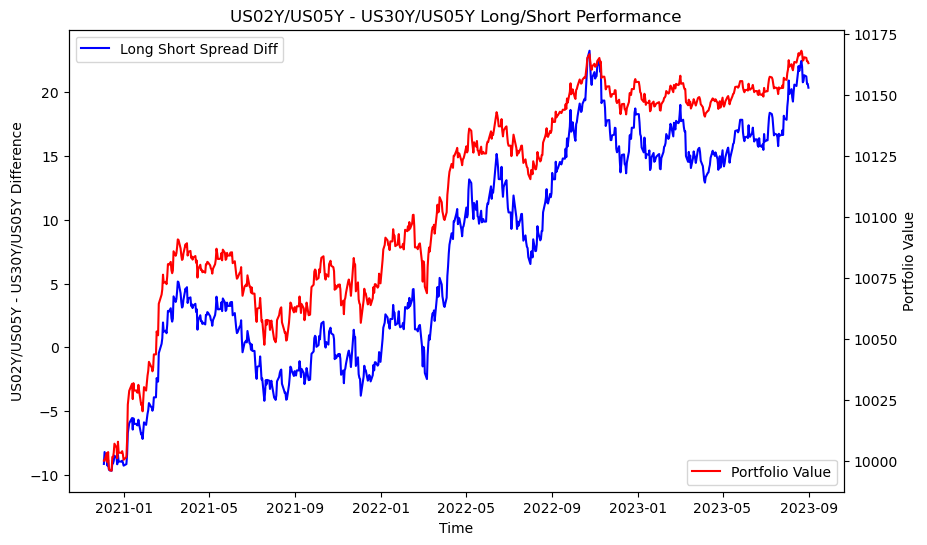

In [81]:
us5_us2_minus_us30_us5_df = (difference_df['spread_TUFV'] - difference_df['spread_USFV']).to_frame(name='long_short_spread_diff')
us5_us2_minus_us30_us5_df['returns'] = (us5_us2_minus_us30_us5_df['long_short_spread_diff'] + 20).pct_change().fillna(0)
buy_hold_series = compute_portfolio_value_series(us5_us2_minus_us30_us5_df['returns'], buy_hold_signal)


plot_ma_portfolio_performance(us5_us2_minus_us30_us5_df['long_short_spread_diff'],
                               pd.Series(dtype='float64'),
                               pd.Series(dtype='float64'),
                               buy_hold_series,
                               y_label_left='US02Y/US05Y - US30Y/US05Y Difference',
                               title='US02Y/US05Y - US30Y/US05Y Long/Short Performance'
                               )

In [82]:
compute_portfolio_statistics(buy_hold_series, signals=buy_hold_signal)

,Portfolio Return Statistics
Count,714.0000
Mean,0.0000
Std,0.0003
Min,-0.0011
25%,-0.0002
50%,0.0000
75%,0.0002
Max,0.0014
Trade Count,1.0000
Buy Count,1.0000


## V. Conclusion: Summary of Results

### 1. Report Conclusion
---

In this analysis, we began by pulling, filtering, and cleaning data from Quandl (the source of data). We then created the spread between the US02Y/US05Y treasury futures and the US30Y/US05Y treasury futures.

For both spreads, we observed that the futures reflected the changes in the yield curves during the period from December 3, 2020, to August 31, 2023, when the US Federal Reserve aggressively hiked interest rates. The US02Y/US05Y spread trended upward, indicating that the slope between the US02Y and the US05Y changed from upward sloping to downward sloping. The US30Y/US05Y spread, on the other hand, trended downward because the longer-dated maturity came first. However, it still indicated the same observation from the yield curve. The spread going downwards meant that the curve between the 5-year maturity and the 30-year maturity changed from upward sloping to downward sloping.

Looking at the dynamics of the spreads, we observed a very high correlation between the two spreads from the regression. We also found that the US30Y/US05Y spread moved about 1.456 per unit move of the US05Y/US02Y spread. This indicated to us that the longer-dated maturities are more sensitive to rate changes, likely due to the larger duration of the longer-dated bonds.

We devised two simple trading strategies from the prior observations, although both were in-sample and after looking at the data. However, for demonstration purposes, we showed what type of trades could work if an investor wanted exposure to the yield curve shifting up and steepening downwards.

Overall, we observed the impact of the yield curve changes on these treasury future prices, spreads, and returns. It provided us insight into the direction and magnitude of the price sensitivity to yield curve changes during a period of aggressive rate hikes by the US Federal Reserve.